<a href="https://colab.research.google.com/github/INT-Group-9/ColabNotebook/blob/Jake/cifa10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [115]:
trainSet = datasets.CIFAR10("./data", train=True, download = True,
                         transform = transforms.Compose([
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomCrop(32, padding=4),
                            transforms.ToTensor()]))

testSet = datasets.CIFAR10("./data", train=False, download=True,
                         transform = transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [116]:
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=64, shuffle=True)

In [117]:
# class Net(nn.Module):

#   def __init__(self):
#     super().__init__()
#     self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride = 1)
#     self.pool = nn.MaxPool2d(2, 2)
#     self.conv2 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride = 1, padding=1)

#     self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride = 1)
#     # self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride = 1)

#     self.fc1 = nn.Linear(in_features = 16*5*5, out_features=120)
#     self.fc2 = nn.Linear(in_features = 120, out_features=10)
#     # self.fc3 = nn.Linear(in_features = 120, out_features=10)
  
#   def forward(self, input):
#     output = self.pool(F.relu(self.conv1(input)))
#     # print(output.shape)
#     output = self.pool(F.relu(self.conv2(output)))
#     output = F.relu(self.conv3(output))
#     # print(output.shape)
#     # output = self.pool(F.relu(self.conv4(output)))
#     # print(output.shape)
#     output = output.view(-1, 16 * 5 * 5)

#     output = F.relu(self.fc1(output))
#     output = self.fc2(output)


#     # return F.log_softmax(output, dim=1)
#     return output
    
# net = Net().cuda()


In [118]:
# class Net(nn.Module):

#   def __init__(self):
#     super().__init__()
#     self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#     self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
#     self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
#     self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

#     self.fc1 = nn.Linear(in_features = 64*5*5, out_features=512)
#     self.fc2 = nn.Linear(in_features = 512, out_features=128)
#     self.fc3 = nn.Linear(in_features = 128, out_features=32)
#     self.fc4 = nn.Linear(in_features = 32, out_features=10)
#     self.fc5 = nn.Linear(in_features = 10, out_features=10)

#     self.pool = nn.MaxPool2d(2, 2)

#   def forward(self, input):
#     output = F.relu(self.conv1(input))
#     output = F.relu(self.conv2(output))
#     output = self.pool(output)
#     output = F.relu(self.conv3(output))
#     output = F.relu(self.conv4(output))
#     output = self.pool(output)
#     output = output.view(-1, 5 * 5 * 64)

#     output = F.relu(self.fc1(output))
#     output = F.relu(self.fc2(output))
#     output = F.relu(self.fc3(output))
#     output = F.relu(self.fc4(output))
#     output = self.fc5(output)

#     return F.softmax(output, dim=1)
#     # return output
    
# net = Net().cuda()


In [119]:
class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.batch1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.batch2 = nn.BatchNorm2d(128)

    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.batch3 = nn.BatchNorm2d(256)


    self.fc1 = nn.Linear(in_features = 256 * 4 * 4, out_features=1024)
    self.fc2 = nn.Linear(in_features = 1024, out_features=512)
    self.fc3 = nn.Linear(in_features = 512, out_features=10)
    self.dropout1 = nn.Dropout(p=0.1)
    self.dropout2 = nn.Dropout(p=0.05)

    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, input):
    output = self.conv1(input)
    output = self.batch1(output)
    output = F.relu(output)
    output = F.relu(self.conv2(output))
    output = self.pool(output)

    output = self.conv3(output)
    output = self.batch2(output)
    output = F.relu(output)
    output = F.relu(self.conv4(output))
    output = self.pool(output)
    output = self.dropout2(output)

    output = self.conv5(output)
    output = self.batch3(output)
    output = F.relu(output)
    output = F.relu(self.conv6(output))
    output = self.pool(output)

    # output = output.view(-1, 256 * 4 * 4)
    output = output.view(output.size(0), -1)

    output = self.dropout1(output)
    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.dropout1(output)
    output = self.fc3(output)
    # output = F.relu(self.fc4(output))
    # output = self.fc5(output)

    # return F.softmax(output, dim=1)
    return output
    
net = Net().cuda()


In [120]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
# criterion = nn.PoissonNLLLoss()
# criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

In [121]:
import tqdm

for epoch in range(3):  # loop over the dataset multiple times

    print("epoch", epoch + 1)
    running_loss = 0.0
    for i, data in enumerate(tqdm.notebook.tqdm(trainLoader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += loss.item()
        # running_loss /= len(trainLoader)
        #if i % 50 == 0:    # print every 2000 mini-batches
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #running_loss = 0.0

print('Finished Training')

epoch 1



epoch 2



epoch 3



Finished Training


In [122]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [123]:
dataiter = iter(testLoader)
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()

# print images
# plt.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:   frog  frog  ship truck


In [124]:
net = Net().cuda()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog  frog  ship truck


In [125]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73 %


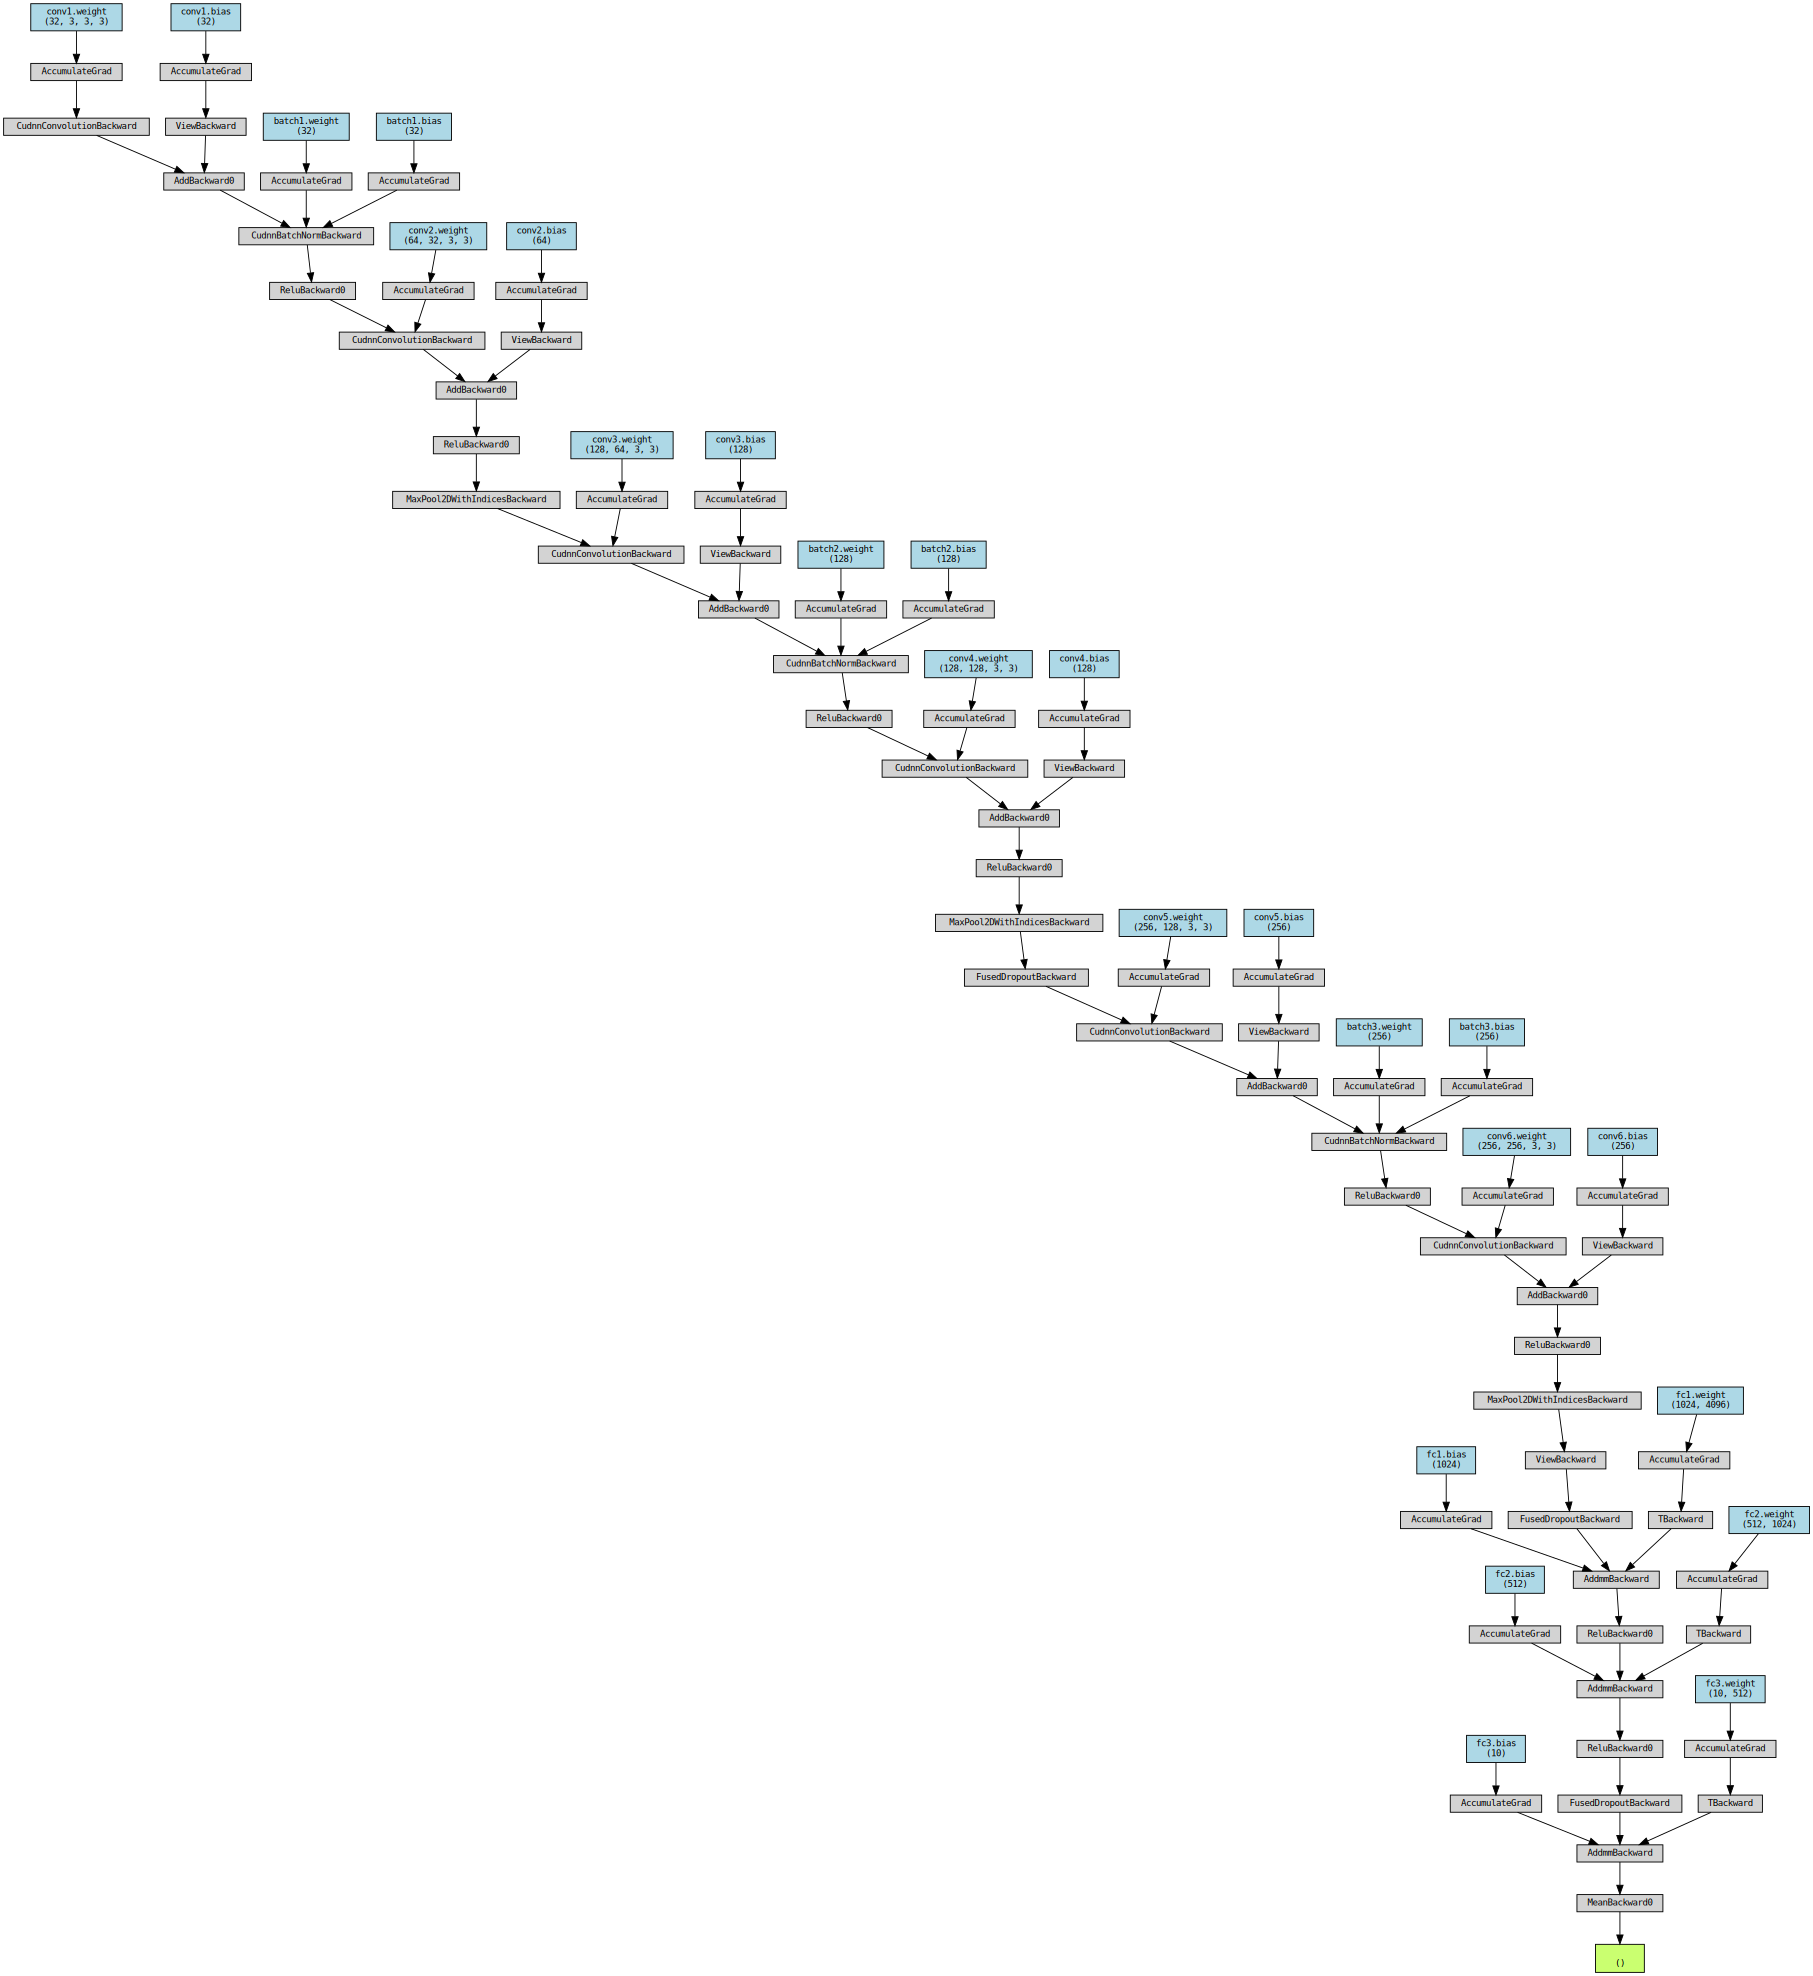

In [128]:
from torchviz import make_dot
batch = next(iter(trainLoader))
inputs, labels = batch
inputs, labels = inputs.cuda(), labels.cuda()
# batch = Variable(torch.randn(1,8))
y = net(inputs) # Give dummy batch to forward().
# make_dot(y, params=dict(list(net.named_parameters()))).render("rnn_torchviz", format="png")
make_dot(y.mean(), params=dict(list(net.named_parameters())))

